In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
import pickle as pkl
from tqdm import tqdm

from sim_biology import p, load_dataloader_and_pretrained_model
# adaptive-wavelets modules
sys.path.append('../../src')
sys.path.append('../../src/adaptive_wavelets')
from losses import get_loss_f
from train import Trainer, Validator
from transform1d import DWT1d
from utils import get_1dfilts
from wave_attributions import Attributer
from visualize import cshow, plot_1dreconstruct, plot_1dfilts

In [43]:
sys.path.append('../../lib/trim')
from trim import TrimModel
from losses import _L1_attribution_loss, _reconstruction_loss, _sum_loss, _L2norm_loss, _CMF_loss, _L1_wave_loss

## load data and model

In [20]:
# get dataloader and model
(train_loader, test_loader), model = load_dataloader_and_pretrained_model(p)

In [404]:
# wavelet transform 
torch.manual_seed(p.seed)
wt = DWT1d(wave='db5', mode='symmetric', J=5, init_factor=1, noise_factor=0.1).to(device)
mt = TrimModel(model, wt.inverse, use_residuals=True)    
attributer = Attributer(mt, attr_methods='InputXGradient', device=device)

# get image
data = iter(test_loader).next()[0].to(device)
data_t = wt(data)
recon_data = wt.inverse(data_t)
with torch.backends.cudnn.flags(enabled=False):
    attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))

In [405]:
# loss = _reconstruction_loss(data, recon_data)
# loss = _sum_loss(wt)
# loss = _L2norm_loss(wt)
# loss = _CMF_loss(wt)
# loss = _L1_wave_loss(data_t) 
# loss = _L1_attribution_loss(attributions)
# loss.backward()

## optimize filter

In [406]:
# train
params = list(wt.parameters())
optimizer = torch.optim.Adam(params, lr=0.00001)

epochs = 100
train_losses = np.empty(epochs)
wt.train()

for epoch in range(epochs):
    epoch_loss = 0.
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        # zero grad
        optimizer.zero_grad()
        # transform
        data_t = wt(data)
        # reconstruction
        recon_data = wt.inverse(data_t)
        # loss
        with torch.backends.cudnn.flags(enabled=False):
            attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
        loss = _L1_attribution_loss(attributions)

        # backward
        loss.backward()
        # update step
        optimizer.step()
        epoch_loss += loss.item()   
        
    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses[epoch] = mean_epoch_loss
    print('====> Epoch: {} Average train loss: {:.4f}'.format(epoch, mean_epoch_loss))


====> Epoch: 0 Average train loss: 0.4312
====> Epoch: 1 Average train loss: 0.4315
====> Epoch: 2 Average train loss: 0.4305
====> Epoch: 3 Average train loss: 0.4294
====> Epoch: 4 Average train loss: 0.4293
====> Epoch: 5 Average train loss: 0.4297
====> Epoch: 6 Average train loss: 0.4290
====> Epoch: 7 Average train loss: 0.4283
====> Epoch: 8 Average train loss: 0.4290
====> Epoch: 9 Average train loss: 0.4281
====> Epoch: 10 Average train loss: 0.4255
====> Epoch: 11 Average train loss: 0.4278
====> Epoch: 12 Average train loss: 0.4268
====> Epoch: 13 Average train loss: 0.4256
====> Epoch: 14 Average train loss: 0.4238
====> Epoch: 15 Average train loss: 0.4230
====> Epoch: 16 Average train loss: 0.4231
====> Epoch: 17 Average train loss: 0.4245
====> Epoch: 18 Average train loss: 0.4227
====> Epoch: 19 Average train loss: 0.4220
====> Epoch: 20 Average train loss: 0.4248
====> Epoch: 21 Average train loss: 0.4212
====> Epoch: 22 Average train loss: 0.4207
====> Epoch: 23 Avera

In [407]:
# test
wt.eval()
for batch_idx, (data, _) in enumerate(test_loader):
    data = data.to(device)
    # zero grad
    optimizer.zero_grad()
    # transform
    data_t = wt(data)
    # reconstruction
    recon_data = wt.inverse(data_t)
    # loss
    with torch.backends.cudnn.flags(enabled=False):
        attributions = attributer(data_t, target=0, additional_forward_args=deepcopy(data))
    loss = _L1_attribution_loss(attributions)

    # backward
    loss.backward()
    # update step
    optimizer.step()
    epoch_loss += loss.item()   
        
mean_epoch_loss = epoch_loss / (batch_idx + 1)
print('====> Average test loss: {:.4f}'.format(mean_epoch_loss))


====> Average test loss: 1.4528


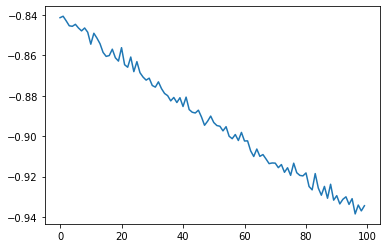

In [408]:
plt.plot(np.log(train_losses))